# Multimodal RAG with Image Generation

This notebook demonstrates a complete multimodal RAG (Retrieval-Augmented Generation) system that combines:

- **Image and Text Embeddings**: Using CLIP for images and multilingual E5 for text
- **Vector Database**: Qdrant for efficient similarity search
- **Content Generation**: Qwen2.5-VL for generating descriptions from retrieved examples
- **Advanced Retrieval**: MMR (Maximal Marginal Relevance) and deduplication

## Features
- Multi-modal search (text-to-image, image-to-image)
- Cross-modal reranking using CLIP
- MMR diversification to avoid redundant results
- Content generation inspired by retrieved examples
- Support for multilingual text (including Bangla)

## Table of Contents
1. [Setup and Installation](#setup)
2. [Configuration](#config)
3. [Data Loading and Utilities](#data)
4. [Embedding Models](#embeddings)
5. [Vector Database (Qdrant)](#qdrant)
6. [Data Ingestion](#ingestion)
7. [Search and Retrieval](#search)
8. [Content Generation](#generation)
9. [Complete Workflow Example](#workflow)
10. [Advanced Features](#advanced)


## 1. Setup and Installation {#setup}

First, let's install the required dependencies and import the necessary libraries.

**Required packages:**
- `sentence-transformers`: For embedding models (CLIP, E5)
- `qdrant-client`: Vector database client
- `transformers`: For the Qwen2.5-VL generation model
- `torch`: PyTorch for deep learning
- `pillow`: Image processing
- `tqdm`: Progress bars
- `numpy`: Numerical operations


In [43]:
# Install required packages (run this cell if packages are not installed)
import sys
!{sys.executable} -m pip install -U matplotlib sentence-transformers qdrant-client pandas torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

# Core imports
import os
import uuid
import json
import math
from typing import List, Dict, Any
import numpy as np
from PIL import Image
from tqdm import tqdm

# Embedding models
from sentence_transformers import SentenceTransformer

# Vector database
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams, PointStruct

# Generation model
from transformers import AutoProcessor
from transformers.models.qwen2_5_vl import Qwen2_5_VLForConditionalGeneration

print("All imports successful!")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://download.pytorch.org/whl/cpu
All imports successful!


## 2. Configuration {#config}

Define the configuration parameters for our multimodal RAG system.

**Key Components:**
- **CLIP ViT-L/14**: For image embeddings and cross-modal text-image understanding
- **Multilingual E5**: For text embeddings with support for multiple languages including Bangla
- **Qdrant**: In-memory vector database for this demo (can be configured for server mode)
- **Qwen2.5-VL-7B**: Vision-language model for content generation


In [44]:
# Embedding Models
IMG_EMB = "sentence-transformers/clip-ViT-L-14"  # CLIP for cross-modal embeddings
TXT_EMB = "intfloat/multilingual-e5-base"        # Multilingual text embeddings

# Vector Database
COLLECTION = "mm_posts"  # Collection name in Qdrant
USE_SERVER = False       # Use in-memory Qdrant for demo
QHOST, QPORT = "localhost", 6333  # Qdrant server settings

# Retrieval Parameters
TOPK_INIT = 24          # Initial number of candidates
TOPK_FINAL = 6          # Final number after reranking
MMR_LAMBDA = 0.7        # MMR diversification factor (0=relevance, 1=diversity)
DEDUP_THR = 0.96        # Deduplication threshold (cosine similarity)

# Generation Model
GEN_MODEL_ID = "Qwen/Qwen2.5-VL-3B-Instruct"

print("Configuration loaded successfully!")


Configuration loaded successfully!


## 3. Data Loading and Utilities {#data}

This section contains utility functions for data loading, normalization, and basic operations.

**Key Functions:**
- `load_json_any()`: Flexible JSON/JSONL loading
- `norm()`: Vector normalization for cosine similarity
- Error handling for file operations


In [45]:
def load_json_any(path: str) -> List[Dict[str, Any]]:
    """
    Load JSON data from file, supporting both JSON array and JSONL formats.
    
    Args:
        path: Path to the JSON/JSONL file
        
    Returns:
        List of dictionaries containing the loaded data
        
    Example:
        # JSON format: [{"image": "img1.jpg", "caption": "..."}, ...]
        # JSONL format: {"image": "img1.jpg", "caption": "..."}\n{"image": "img2.jpg", ...}
    """
    try:
        with open(path, "r", encoding="utf-8") as f:
            txt = f.read().strip()
        
        if txt.startswith("["):
            # Standard JSON array format
            return json.loads(txt)
        else:
            # JSONL format (one JSON object per line)
            return [json.loads(line) for line in txt.splitlines() if line.strip()]
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return []

def norm(v: np.ndarray) -> np.ndarray:
    """
    Normalize vectors for cosine similarity computation.
    
    Args:
        v: Input vectors of shape (n_samples, n_features)
        
    Returns:
        Normalized vectors (L2 norm = 1)
        
    Note:
        Handles zero vectors by setting them to unit vectors
    """
    n = np.linalg.norm(v, axis=1, keepdims=True)
    n[n == 0] = 1  
    return v / n

# Test the utility functions
print("Utility functions defined successfully!")


posts = load_json_any("/Users/sayems_mac/BrandReview/brandReviewModels/RAG_pipeline/posts_data.json")
print(f"Loaded {len(posts)} posts")

# show some post images and captions



Utility functions defined successfully!
Loaded 120 posts


Loaded 120 posts
Found 91 posts with images out of 120 total posts

POST 1
Image: 2025-05-20.jpg
Date: 2025-05-20
Caption: 
Description: Announcement that Starlink users receive free Delivery Hobe orders; simple graphic with a rocket and Delivery Hobe logo.
Engagement:
  - Reactions: 174
  - Comments: 10
  - Shares: 0

POST 2
Image: 2025-08-27.jpg
Date: 2025-08-27 08:49
Caption: Ekhon apnar naam er aage Engr. boshan
Description: Photo of a young boy in graduation gown holding a bag of Diploma powdered milk while adults adjust his cap, humorously suggesting the title ‘Engineer’ for buying powdered milk.
Engagement:
  - Reactions: 3,900
  - Comments: 169
  - Shares: 590

POST 3
Image: 2025-03-13.jpg
Date: 2025-03-13
Caption: 
Description: Photo of a Delivery Hobe representative standing behind a booth at an entrepreneurs’ event; the table displays snacks and hygiene products with company signage.
Engagement:
  - Reactions: 50
  - Comments: 4
  - Shares: 1

POST 4
Image: 2025-07-26.jpg
Da

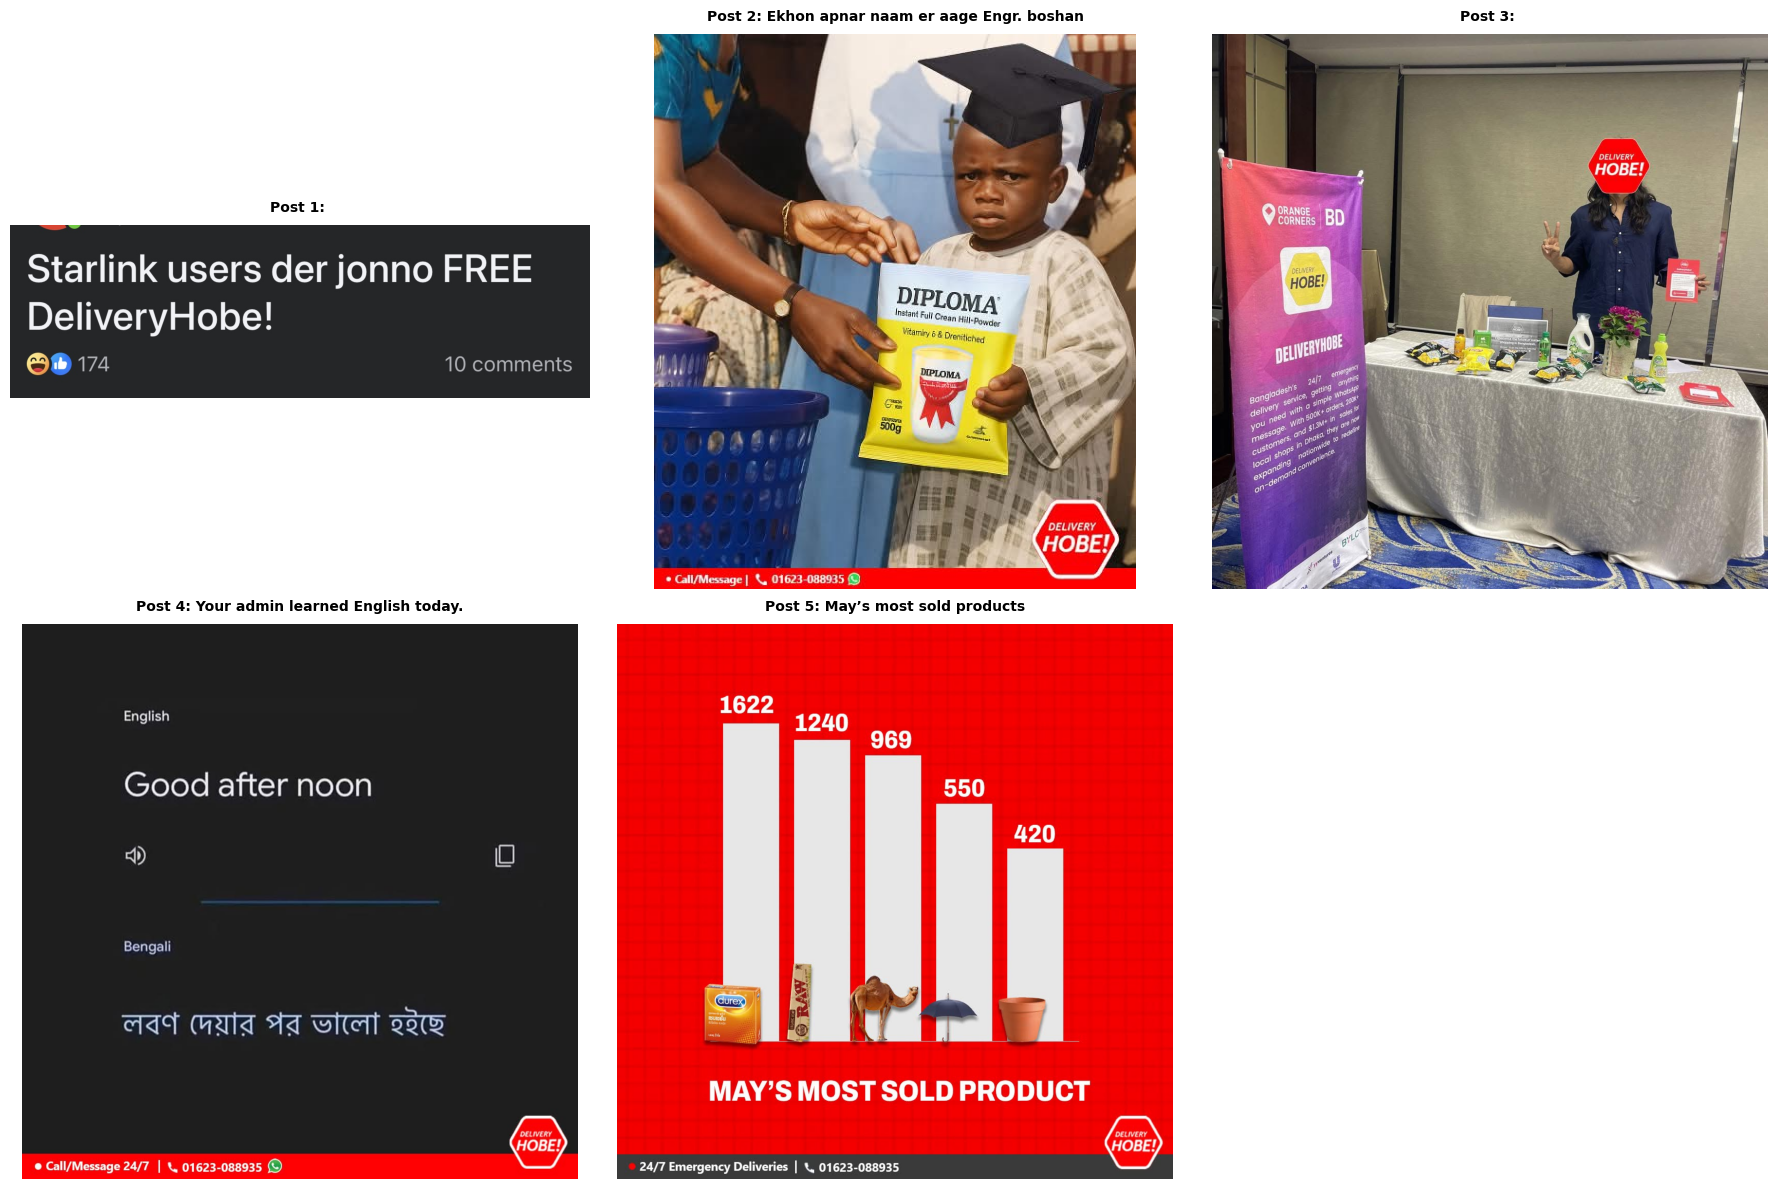

In [46]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os
import json
from typing import List, Dict, Any
import numpy as np
import random

def load_json_any(path: str) -> List[Dict[str, Any]]:
    """
    Load JSON data from file, supporting both JSON array and JSONL formats.
    
    Args:
        path: Path to the JSON/JSONL file
        
    Returns:
        List of dictionaries containing the loaded data
        
    Example:
        # JSON format: [{"image": "img1.jpg", "caption": "..."}, ...]
        # JSONL format: {"image": "img1.jpg", "caption": "..."}\n{"image": "img2.jpg", ...}
    """
    try:
        with open(path, "r", encoding="utf-8") as f:
            txt = f.read().strip()
        
        if txt.startswith("["):
            # Standard JSON array format
            return json.loads(txt)
        else:
            # JSONL format (one JSON object per line)
            return [json.loads(line) for line in txt.splitlines() if line.strip()]
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return []

def display_posts_with_images(posts: List[Dict], images_dir: str, num_posts: int = 5):
    """
    Display posts with their images, captions, and details.
    
    Args:
        posts: List of post dictionaries
        images_dir: Directory containing the images
        num_posts: Number of posts to display
    """
    # Filter posts that have images
    posts_with_images = [post for post in posts if post.get('image') and post['image'].strip()]
    
    print(f"Found {len(posts_with_images)} posts with images out of {len(posts)} total posts")


    random.shuffle(posts_with_images)

    
    # Take the first num_posts posts with images
    posts_to_show = posts_with_images[:num_posts]
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, post in enumerate(posts_to_show):
        if i >= len(axes):
            break
            
        image_path = os.path.join(images_dir, post['image'])
        
        try:
            # Load and display image
            img = Image.open(image_path)
            axes[i].imshow(img)
            axes[i].set_title(f"Post {i+1}: {post.get('caption', 'No caption')}", 
                            fontsize=10, fontweight='bold', pad=10)
            axes[i].axis('off')
            
            # Print post details
            print(f"\n{'='*60}")
            print(f"POST {i+1}")
            print(f"{'='*60}")
            print(f"Image: {post.get('image', 'N/A')}")
            print(f"Date: {post.get('date', 'N/A')}")
            print(f"Caption: {post.get('caption', 'N/A')}")
            print(f"Description: {post.get('description', 'N/A')}")
            
            if 'engagement' in post:
                eng = post['engagement']
                print(f"Engagement:")
                print(f"  - Reactions: {eng.get('reactions', 0):,}")
                print(f"  - Comments: {eng.get('comments', 0):,}")
                print(f"  - Shares: {eng.get('shares', 0):,}")
            
        except Exception as e:
            print(f"Error loading image {post['image']}: {e}")
            axes[i].text(0.5, 0.5, f"Error loading\n{post['image']}", 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f"Post {i+1}: Error", fontsize=10)
            axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(posts_to_show), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return posts_to_show

# Load posts data
posts = load_json_any("/Users/sayems_mac/BrandReview/brandReviewModels/RAG_pipeline/posts_data.json")
print(f"Loaded {len(posts)} posts")

# Display 5 posts with images
images_directory = "/Users/sayems_mac/BrandReview/brandReviewModels/RAG_pipeline/images"
displayed_posts = display_posts_with_images(posts, images_directory, num_posts=5)


## 4. Embedding Models {#embeddings}

This section implements the embedding models for both images and text.

**Models Used:**
- **CLIP ViT-L/14**: For image embeddings and cross-modal text-image understanding
- **Multilingual E5**: For text embeddings with excellent multilingual support

**Key Features:**
- Lazy loading (models loaded only when needed)
- Automatic normalization for cosine similarity
- Support for both query and passage text encoding (E5 requirement)


In [47]:
# Global variables for model caching (lazy loading)
IMG = None
TXT = None

def get_img_encoder():
    """
    Get the image encoder (CLIP ViT-L/14).
    Uses global caching to avoid reloading the model.
    
    Returns:
        SentenceTransformer model for image embeddings
    """
    global IMG
    if IMG is None:
        print("Loading CLIP ViT-L/14 model...")
        IMG = SentenceTransformer(IMG_EMB)
        print("Image encoder loaded successfully!")
    return IMG

def get_txt_encoder():
    """
    Get the text encoder (Multilingual E5).
    Uses global caching to avoid reloading the model.
    
    Returns:
        SentenceTransformer model for text embeddings
    """
    global TXT
    if TXT is None:
        print("Loading Multilingual E5 model...")
        TXT = SentenceTransformer(TXT_EMB)
        print("Text encoder loaded successfully!")
    return TXT

def emb_image(paths: List[str]) -> np.ndarray:
    """
    Generate embeddings for a list of images.
    
    Args:
        paths: List of image file paths
        
    Returns:
        Normalized image embeddings of shape (n_images, embedding_dim)
        
    Note:
        Images are automatically converted to RGB format
    """
    enc = get_img_encoder()
    imgs = [Image.open(p).convert("RGB") for p in paths]
    return enc.encode(imgs, convert_to_numpy=True, normalize_embeddings=True).astype("float32")

def emb_text(texts: List[str], mode: str) -> np.ndarray:
    """
    Generate embeddings for text with proper E5 prefixing.
    
    Args:
        texts: List of text strings to embed
        mode: Either "query" or "passage" (affects E5 prefixing)
        
    Returns:
        Normalized text embeddings of shape (n_texts, embedding_dim)
        
    Note:
        E5 model requires specific prefixes: "query: " for queries, "passage: " for passages
    """
    prefix = "query: " if mode == "query" else "passage: "
    enc = get_txt_encoder()
    prefixed_texts = [prefix + t for t in texts]
    return enc.encode(prefixed_texts, convert_to_numpy=True, normalize_embeddings=True).astype("float32")

print("Embedding functions defined successfully!")


Embedding functions defined successfully!


## 5. Vector Database (Qdrant) {#qdrant}

This section implements the vector database operations using Qdrant.

**Qdrant Features:**
- **Multi-vector support**: Separate vectors for images and text
- **Cosine similarity**: Optimized for normalized embeddings
- **In-memory mode**: For demo purposes (can be configured for server mode)
- **Collection management**: Automatic recreation and cleanup

**Collection Structure:**
- **image**: CLIP embeddings (768 dimensions)
- **text**: E5 embeddings (768 dimensions)
- **payload**: Metadata (image path, caption, description, etc.)


In [48]:
# Global Qdrant client (lazy loading)
_Q = None

def qdrant() -> QdrantClient:
    """
    Get Qdrant client instance.
    Uses global caching and supports both in-memory and server modes.
    
    Returns:
        QdrantClient instance
    """
    global _Q
    if _Q is None:
        if USE_SERVER:
            print(f"Connecting to Qdrant server at {QHOST}:{QPORT}")
            _Q = QdrantClient(host=QHOST, port=QPORT)
        else:
            print("Using in-memory Qdrant database")
            _Q = QdrantClient(":memory:")
    return _Q

def recreate_collection(dim_img: int, dim_txt: int):
    """
    Create or recreate the vector collection with specified dimensions.
    
    Args:
        dim_img: Dimension of image embeddings
        dim_txt: Dimension of text embeddings
        
    Note:
        This will delete any existing collection with the same name
    """
    qc = qdrant()
    
    # Check if collection exists and delete it
    try:
        existing_collections = [c.name for c in qc.get_collections().collections]
        if COLLECTION in existing_collections:
            print(f"Deleting existing collection '{COLLECTION}'")
            qc.delete_collection(COLLECTION)
    except Exception as e:
        print(f"Warning: Could not check existing collections: {e}")
    
    # Create new collection
    print(f"Creating collection '{COLLECTION}' with image dim={dim_img}, text dim={dim_txt}")
    qc.recreate_collection(
        collection_name=COLLECTION,
        vectors_config={
            "image": VectorParams(size=dim_img, distance=Distance.COSINE),
            "text": VectorParams(size=dim_txt, distance=Distance.COSINE),
        }
    )
    print(f"Collection '{COLLECTION}' created successfully!")

def upsert(points: List[PointStruct]):
    """
    Insert or update points in the collection.
    
    Args:
        points: List of PointStruct objects containing vectors and payloads
    """
    qdrant().upsert(collection_name=COLLECTION, points=points)
    print(f"Upserted {len(points)} points to collection '{COLLECTION}'")

print("Qdrant functions defined successfully!")


Qdrant functions defined successfully!


## 6. Data Ingestion {#ingestion}

This section implements the data ingestion pipeline that processes posts and creates embeddings.

**Ingestion Process:**
1. **Load Data**: Parse JSON/JSONL files containing posts
2. **Prepare Images**: Extract image paths and load images
3. **Generate Embeddings**: Create both image and text embeddings
4. **Create Collection**: Set up Qdrant collection with proper dimensions
5. **Store Data**: Insert embeddings with metadata into vector database

**Data Format Expected:**
```json
{
  "image": "filename.jpg",
  "caption": "Image caption",
  "description": "Detailed description",
  "additional_field": "any other metadata"
}
```


In [49]:
def ingest(posts_json: str, images_dir):
    """
    Complete ingestion pipeline for multimodal posts.
    
    Args:
        posts_json: Path to JSON/JSONL file containing posts
        images_dir: Directory containing the image files
        
    Process:
        1. Load and parse posts data
        2. Extract image paths and prepare text content
        3. Generate image embeddings using CLIP
        4. Generate text embeddings using E5
        5. Create Qdrant collection with proper dimensions
        6. Store all data as points in the vector database
    """
    print("=== Starting Data Ingestion ===")
    
    # Step 1: Load posts data
    print(f"Loading posts from {posts_json}...")
    posts = load_json_any(posts_json)

    if not posts:
        print("No posts loaded. Exiting.")
        return
    
    print(f"Loaded {len(posts)} posts")
    
    # Step 2: Prepare data
    print("Preparing image paths and text content...")
    paths = images_dir
    caps = [p.get("caption", "") for p in posts]
    descs = [p.get("description", "") for p in posts]
    
    # Combine caption and description for text embedding
    texts = [f"caption: {c}\n\ndescription: {d}" for c, d in zip(caps, descs)]
    
    # Step 3: Generate embeddings
    print(f"Generating embeddings for {len(paths)} images...")
    v_img = emb_image(paths)
    
    print(f"Generating embeddings for {len(texts)} text descriptions...")
    v_txt = emb_text(texts, mode="passage")
    
    print(f"Image embeddings shape: {v_img.shape}")
    print(f"Text embeddings shape: {v_txt.shape}")
    
    # Step 4: Create collection
    recreate_collection(v_img.shape[1], v_txt.shape[1])
    
    # Step 5: Create points and store
    print("Creating vector database points...")
    points = []
    
    for vi, vt, p, c, d in zip(v_img, v_txt, posts, caps, descs):
        # Create payload with all original data
        payload = {
            "image": p["image"],
            "caption": c,
            "description": d,
            # Include any additional fields from the original post
            **{k: v for k, v in p.items() if k not in ["image", "caption", "description"]}
        }
        
        # Create point with both image and text vectors
        point = PointStruct(
            id=str(uuid.uuid4()),
            vector={"image": vi.tolist(), "text": vt.tolist()},
            payload=payload
        )
        points.append(point)
    
    # Store in vector database
    upsert(points)
    print(f"=== Ingestion Complete: {len(points)} items stored ===")

print("Ingestion function defined successfully!")


Ingestion function defined successfully!


## 7. Search and Retrieval {#search}

This section implements advanced search and retrieval capabilities with reranking and diversification.

**Search Types:**
- **Text-to-Image**: Find images similar to a text query
- **Image-to-Image**: Find images similar to a query image

**Advanced Features:**
- **Cross-modal Reranking**: Use CLIP for text-image similarity
- **MMR Diversification**: Avoid redundant results using Maximal Marginal Relevance
- **Deduplication**: Remove highly similar results
- **Multi-stage Retrieval**: Initial ANN search + reranking + diversification


In [50]:
def search_by_text(query: str, topk: int) -> List[Dict[str, Any]]:
    """
    Search for images using a text query.
    
    Args:
        query: Text query string
        topk: Number of results to return
        
    Returns:
        List of search results with scores and payloads
    """
    qv = emb_text([query], mode="query")[0]
    res = qdrant().search(
        collection_name=COLLECTION,
        query_vector=("text", qv.tolist()),
        limit=topk,
        with_payload=True
    )
    return [{"score": r.score, "payload": r.payload} for r in res]

def search_by_image(img_path: str, topk: int) -> List[Dict[str, Any]]:
    """
    Search for similar images using an image query.
    
    Args:
        img_path: Path to the query image
        topk: Number of results to return
        
    Returns:
        List of search results with scores and payloads
    """
    qv = emb_image([img_path])[0]
    res = qdrant().search(
        collection_name=COLLECTION,
        query_vector=("image", qv.tolist()),
        limit=topk,
        with_payload=True
    )
    return [{"score": r.score, "payload": r.payload} for r in res]

def cosine(a, b):
    """Compute cosine similarity between two vectors."""
    return float(np.dot(a, b))

def mmr_diversify(vecs: np.ndarray, base_scores: np.ndarray, k: int, lam: float) -> List[int]:
    """
    Apply Maximal Marginal Relevance (MMR) for result diversification.
    
    Args:
        vecs: Normalized vectors (n_samples, n_features)
        base_scores: Relevance scores (n_samples,)
        k: Number of diverse results to select
        lam: Diversification factor (0=relevance only, 1=diversity only)
        
    Returns:
        List of indices for diverse results
        
    Algorithm:
        MMR = λ * Relevance - (1-λ) * max_similarity_to_selected
    """
    chosen = []
    candidates = list(range(len(vecs)))
    
    while candidates and len(chosen) < k:
        if not chosen:
            # Select the most relevant item first
            i = int(np.argmax(base_scores[candidates]))
            chosen.append(candidates.pop(candidates.index(i)))
            continue
        
        # Compute MMR scores for remaining candidates
        selected_vecs = np.stack([vecs[i] for i in chosen], 0)  # (m, d)
        similarities = vecs[candidates] @ selected_vecs.T  # (c, m)
        
        # MMR formula
        mmr_scores = lam * base_scores[candidates] - (1 - lam) * np.max(similarities, axis=1)
        
        # Select the item with highest MMR score
        i = candidates[int(np.argmax(mmr_scores))]
        candidates.remove(i)
        chosen.append(i)
    
    return chosen

def dedup_keep(vecs: np.ndarray, threshold: float) -> List[int]:
    """
    Remove duplicate vectors based on cosine similarity threshold.
    
    Args:
        vecs: Normalized vectors (n_samples, n_features)
        threshold: Similarity threshold for deduplication
        
    Returns:
        List of indices to keep (removing duplicates)
    """
    keep = []
    for i, v in enumerate(vecs):
        # Check if this vector is too similar to any already kept vector
        is_duplicate = any(float(v @ vecs[j]) >= threshold for j in keep)
        if not is_duplicate:
            keep.append(i)
    return keep

print("Search and retrieval functions defined successfully!")


Search and retrieval functions defined successfully!


In [51]:
def post_process_for_text_query(query: str, hits: List[Dict[str, Any]], images_dir) -> List[Dict[str, Any]]:
    """
    Advanced post-processing for text queries with cross-modal reranking, MMR, and deduplication.
    
    Args:
        query: Original text query
        hits: Initial search results from text vector search
        images_dir: Directory containing images (required for image path resolution)
        
    Returns:
        Reranked and diversified results
        
    Process:
        1. Extract image paths from hits
        2. Generate CLIP embeddings for images
        3. Rerank using CLIP text-image similarity
        4. Apply MMR diversification
        5. Remove duplicates
    """
    if not hits:
        return []
    
    if images_dir is None:
        print("Warning: images_dir not provided, using original hits without reranking")
        return hits
    
    print(f"Post-processing {len(hits)} hits with cross-modal reranking...")
    
    # Step 1: Extract image paths and generate CLIP embeddings
    img_paths = [h["payload"]["image"] for h in hits]
    full_img_paths = images_dir
    img_vecs = emb_image(full_img_paths)
    
    # Step 2: Cross-modal reranking using CLIP
    # Use CLIP's text encoder to get query embedding
    clip_txt = SentenceTransformer(IMG_EMB)  # CLIP text tower
    q_clip = clip_txt.encode([query], convert_to_numpy=True, normalize_embeddings=True).astype("float32")[0]
    
    # Compute text-image similarities
    relevance_scores = img_vecs @ q_clip  # cosine similarity (both normalized)
    
    # Step 3: Apply MMR diversification
    final_k = min(TOPK_FINAL, len(hits))
    diverse_indices = mmr_diversify(img_vecs, relevance_scores, final_k, MMR_LAMBDA)
    
    # Step 4: Deduplication
    selected_vecs = img_vecs[diverse_indices]
    keep_indices = dedup_keep(selected_vecs, DEDUP_THR)
    
    # Map back to original hit indices
    final_indices = [diverse_indices[i] for i in keep_indices]
    
    print(f"Selected {len(final_indices)} diverse, non-duplicate results")
    return [hits[i] for i in final_indices]

print("Advanced post-processing function defined successfully!")


Advanced post-processing function defined successfully!


In [52]:
# FIXED VERSION: post_process_for_text_query function with bounds checking
def post_process_for_text_query(query: str, hits: List[Dict[str, Any]], images_dir) -> List[Dict[str, Any]]:
    """
    Advanced post-processing for text queries with cross-modal reranking, MMR, and deduplication.
    FIXED VERSION with proper bounds checking to prevent IndexError.
    """
    if not hits:
        return []
    
    if images_dir is None:
        print("Warning: images_dir not provided, using original hits without reranking")
        return hits
    
    print(f"Post-processing {len(hits)} hits with cross-modal reranking...")
    
    try:
        # Step 1: Extract image paths and generate CLIP embeddings
        img_paths = [h["payload"]["image"] for h in hits]
        full_img_paths = images_dir
        img_vecs = emb_image(full_img_paths)
        
        # Step 2: Cross-modal reranking using CLIP
        clip_txt = SentenceTransformer(IMG_EMB)
        q_clip = clip_txt.encode([query], convert_to_numpy=True, normalize_embeddings=True).astype("float32")[0]
        
        # Compute text-image similarities
        relevance_scores = img_vecs @ q_clip
        
        # Step 3: Apply MMR diversification
        final_k = min(TOPK_FINAL, len(hits))
        diverse_indices = mmr_diversify(img_vecs, relevance_scores, final_k, MMR_LAMBDA)
        
        # Step 4: Deduplication with bounds checking
        selected_vecs = img_vecs[diverse_indices]
        keep_indices = dedup_keep(selected_vecs, DEDUP_THR)
        
        # FIX: Add comprehensive bounds checking to prevent IndexError
        print(f"Debug: diverse_indices length: {len(diverse_indices)}")
        print(f"Debug: keep_indices length: {len(keep_indices)}")
        if keep_indices:
            print(f"Debug: keep_indices range: {min(keep_indices)} to {max(keep_indices)}")
        
        # Ensure all keep_indices are within bounds of diverse_indices
        valid_keep_indices = []
        for i in keep_indices:
            if 0 <= i < len(diverse_indices):
                valid_keep_indices.append(i)
            else:
                print(f"Warning: keep_indices[{i}] is out of bounds for diverse_indices (len={len(diverse_indices)})")
        
        if not valid_keep_indices:
            print("Warning: No valid indices after bounds checking, returning top results")
            return hits[:final_k]
        
        # Map back to original hit indices with additional bounds checking
        final_indices = []
        for i in valid_keep_indices:
            diverse_idx = diverse_indices[i]
            if 0 <= diverse_idx < len(hits):
                final_indices.append(diverse_idx)
            else:
                print(f"Warning: diverse_indices[{i}] = {diverse_idx} is out of bounds for hits (len={len(hits)})")
        
        if not final_indices:
            print("Warning: No valid final indices, returning top results")
            return hits[:final_k]
        
        print(f"Selected {len(final_indices)} diverse, non-duplicate results")
        return [hits[i] for i in final_indices]
        
    except Exception as e:
        print(f"Error in post-processing: {e}")
        print("Falling back to original hits")
        return hits[:min(TOPK_FINAL, len(hits))]

print("✅ FIXED post_process_for_text_query function defined successfully!")

✅ FIXED post_process_for_text_query function defined successfully!


## 8. Content Generation {#generation}

This section implements content generation using the Qwen2.5-VL vision-language model.

**Generation Features:**
- **Retrieval-Augmented**: Uses retrieved examples as context
- **Vision-Language Model**: Qwen2.5-VL for understanding both images and text
- **Style Consistency**: Generates content that matches the style of examples
- **Brand-Safe Content**: Configured for appropriate social media content

**Generation Process:**
1. **Context Preparation**: Format retrieved examples as context
2. **Model Loading**: Load Qwen2.5-VL with appropriate settings
3. **Prompt Construction**: Create structured prompt with examples and new image
4. **Content Generation**: Generate description following the established style


## 8.5. Image Generation from Captions {#image_generation}

This section adds image generation capabilities to create images from the generated captions.

**Image Generation Features:**
- **Lightweight Model**: Stable Diffusion XL Turbo optimized for M1 MacBook Pro
- **Fast Generation**: Turbo model for quick inference
- **Caption-to-Image**: Generate images from generated descriptions
- **Style Consistency**: Can be fine-tuned to match your brand style

**Recommended Models:**
- **Stable Diffusion XL Turbo**: Fast, good quality, ~6GB VRAM
- **Stable Diffusion 1.5**: Smaller, faster, ~4GB VRAM  
- **Flux Dev**: Latest model, excellent quality, ~8GB VRAM
- **SDXL-Lightning**: Ultra-fast generation, ~4GB VRAM


In [53]:
# Install additional packages for image generation
import sys
!{sys.executable} -m pip install diffusers accelerate transformers controlnet-aux

# Image generation imports
from diffusers import StableDiffusionXLPipeline, StableDiffusionPipeline
from diffusers import AutoPipelineForText2Image
import torch
from PIL import Image
import os

print("Image generation packages installed successfully!")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Image generation packages installed successfully!


In [54]:
import torch

# Generation style prompt
STYLE_PROMPT = (
    "You are a social content writer. Write ONE vivid sentence (15–30 words), "
    "brand-safe, lightly witty, grounded in the new image/caption and inspired by prior examples. "
    "No hashtags/emojis; do not invent facts beyond what's visible or stated."
)

from typing import List, Dict, Any
from PIL import Image
from transformers import AutoProcessor, AutoModelForVision2Seq
import re

def extract_description_from_response(full_response: str) -> str:
    """
    Extract only the generated description from the model's full response.
    """
    print(f"🔍 Full model response:\n{full_response}\n")
    
    # Method 1: Look for the last "assistant" marker
    if "assistant" in full_response.lower():
        parts = re.split(r'assistant', full_response, flags=re.IGNORECASE)
        if len(parts) > 1:
            assistant_response = parts[-1].strip()
            assistant_response = re.sub(r'^[:\-\s]+', '', assistant_response).strip()
            if assistant_response:
                print(f"✅ Extracted description: {assistant_response}")
                return assistant_response
    
    # Method 2: Look for lines that don't start with system/user markers
    lines = full_response.split('\n')
    for line in lines:
        line = line.strip()
        if (line and 
            not line.startswith(('system', 'user', 'EXAMPLES:', 'CAPTION:', 'DESCRIPTION:', 'NEW CAPTION:', 'Write the description')) and
            not re.match(r'^\[?\d+\]', line) and
            len(line) > 10):
            print(f"✅ Found description: {line}")
            return line
    
    # Method 3: Look for the last substantial line
    substantial_lines = [line.strip() for line in lines if line.strip() and len(line.strip()) > 10]
    if substantial_lines:
        last_line = substantial_lines[-1]
        print(f"✅ Using last substantial line: {last_line}")
        return last_line
    
    # Fallback: return the full response
    print(f"⚠️  Using full response as fallback")
    return full_response

def gen_with_qwen_vl(new_image_path: str, new_caption: str, examples: List[Dict[str, Any]]) -> str:
    model_id = "Qwen/Qwen2.5-VL-3B-Instruct"  # or 7B

    processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)
    model = AutoModelForVision2Seq.from_pretrained(
        model_id,
        trust_remote_code=True,
        torch_dtype="auto",
        device_map="auto",
    )

    ex_lines = []
    for i, e in enumerate(examples, 1):
        cap = e.get("payload", {}).get("caption", "")
        desc = e.get("payload", {}).get("description", "")[:200]
        ex_lines.append(f"[{i}] CAPTION: {cap}")
        ex_lines.append(f"    DESCRIPTION: {desc}")
    example_text = "EXAMPLES:\n" + "\n".join(ex_lines)

    img = Image.open(new_image_path).convert("RGB")

    messages = [
        {"role": "system", "content": STYLE_PROMPT},
        {"role": "user", "content": [
            {"type": "text", "text": f"{example_text}\n\nNEW CAPTION: {new_caption}\nWrite the description for this image:"},
            {"type": "image", "image": img},
        ]},
    ]

    # 1) Build prompt text only (do NOT request tensors here)
    prompt_text = processor.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=False,          # ensure we get a string
    )

    # 2) Convert to tensors with text+image together
    inputs = processor(
        text=[prompt_text],
        images=[img],
        return_tensors="pt",
        padding=True,
    )
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # 3) Generate
    out = model.generate(
        **inputs,
        max_new_tokens=96,
        temperature=0.7,
        top_p=0.9,
        do_sample=True,
        eos_token_id=processor.tokenizer.eos_token_id,
        pad_token_id=processor.tokenizer.pad_token_id,
    )

    # Decode and extract only the assistant's response
    full_response = processor.batch_decode(out, skip_special_tokens=True)[0].strip()
    
    # Extract only the description
    description = extract_description_from_response(full_response)
    
    return description

print("Content generation function defined successfully!")


Content generation function defined successfully!


In [55]:
# Global variable for image generation model caching
IMG_GEN_MODEL = None

def get_image_generator(model_type: str = "sdxl_turbo"):
    """
    Get the image generation model with lazy loading.
    
    Args:
        model_type: Type of model to load
            - "sdxl_turbo": Stable Diffusion XL Turbo (fast, good quality)
            - "sd15": Stable Diffusion 1.5 (smaller, faster)
            - "sdxl_lightning": SDXL Lightning (ultra-fast)
            - "flux_dev": Flux Dev (best quality, larger)
    
    Returns:
        Pipeline for image generation
    """
    global IMG_GEN_MODEL
    
    if IMG_GEN_MODEL is None:
        print(f"Loading {model_type} image generation model...")
        
        # Check if MPS (Apple Silicon) is available
        device = "mps" if torch.backends.mps.is_available() else "cpu"
        torch_dtype = torch.float16 if device != "cpu" else torch.float32
        
        try:
            if model_type == "sdxl_turbo":
                # Fast, good quality model (~6GB VRAM)
                IMG_GEN_MODEL = StableDiffusionXLPipeline.from_pretrained(
                    "stabilityai/sdxl-turbo",
                    torch_dtype=torch_dtype,
                    use_safetensors=True,
                    variant="fp16" if torch_dtype == torch.float16 else None
                )
                
            elif model_type == "sd15":
                # Smaller, faster model (~4GB VRAM)
                IMG_GEN_MODEL = StableDiffusionPipeline.from_pretrained(
                    "runwayml/stable-diffusion-v1-5",
                    torch_dtype=torch.float32,
                    use_safetensors=True,
                    # variant="fp16" if torch_dtype == torch.float16 else None
                )
                
            elif model_type == "sdxl_lightning":
                # Ultra-fast model (~4GB VRAM)
                IMG_GEN_MODEL = StableDiffusionXLPipeline.from_pretrained(
                    "ByteDance/SDXL-Lightning",
                    torch_dtype=torch_dtype,
                    use_safetensors=True,
                    variant="fp16" if torch_dtype == torch.float16 else None
                )
                
            elif model_type == "flux_dev":
                # Best quality, larger model (~8GB VRAM)
                IMG_GEN_MODEL = AutoPipelineForText2Image.from_pretrained(
                    "black-forest-labs/FLUX.1-dev",
                    torch_dtype=torch_dtype,
                    use_safetensors=True,
                    variant="fp16" if torch_dtype == torch.float16 else None
                )
            
            # Move to device and enable memory efficient attention
            IMG_GEN_MODEL = IMG_GEN_MODEL.to(device)
            IMG_GEN_MODEL.enable_attention_slicing()
            IMG_GEN_MODEL.enable_model_cpu_offload()
            
            print(f"Image generation model loaded successfully on {device}!")
            
        except Exception as e:
            print(f"Error loading {model_type}: {e}")
            print("Falling back to SDXL Turbo...")
            IMG_GEN_MODEL = StableDiffusionXLPipeline.from_pretrained(
                "stabilityai/sdxl-turbo",
                torch_dtype=torch_dtype,
                use_safetensors=True
            ).to(device)
    
    return IMG_GEN_MODEL

print("Image generation model loader defined successfully!")


Image generation model loader defined successfully!


In [56]:
def generate_image_from_caption(caption: str, model_type: str = "sdxl_turbo", 
                               width: int = 512, height: int = 512, 
                               num_inference_steps: int = 4, guidance_scale: float = 0.0,
                               save_path: str = None) -> Image.Image:
    """
    Generate an image from a text caption using the specified model.
    
    Args:
        caption: Text description to generate image from
        model_type: Type of model to use (sdxl_turbo, sd15, sdxl_lightning, flux_dev)
        width: Width of generated image (default: 512)
        height: Height of generated image (default: 512)
        num_inference_steps: Number of denoising steps (lower = faster)
        guidance_scale: How closely to follow the prompt (0.0 for turbo models)
        save_path: Optional path to save the generated image
    
    Returns:
        PIL Image object
    """
    print(f"Generating image from caption: '{caption[:50]}...'")
    
    # Get the model
    pipe = get_image_generator(model_type)

    pipe.enable_attention_slicing()
    pipe.to("mps")
    
    # Prepare generation parameters based on model type
    if model_type == "sdxl_turbo":
        # SDXL Turbo works best with 1-4 steps and guidance_scale=0.0
        generator_params = {
            "prompt": caption,
            "width": width,
            "height": height,
            "num_inference_steps": min(num_inference_steps, 4),
            "guidance_scale": 0.0,
            "generator": torch.Generator().manual_seed(42)  # For reproducible results
        }
    elif model_type == "sdxl_lightning":
        # Lightning model is also very fast
        generator_params = {
            "prompt": caption,
            "width": width,
            "height": height,
            "num_inference_steps": min(num_inference_steps, 8),
            "guidance_scale": 0.0,
            "generator": torch.Generator().manual_seed(42)
        }
    elif model_type == "flux_dev":
        # Flux works better with higher guidance and more steps
        generator_params = {
            "prompt": caption,
            "width": width,
            "height": height,
            "num_inference_steps": max(num_inference_steps, 20),
            "guidance_scale": max(guidance_scale, 3.5),
            "generator": torch.Generator().manual_seed(42)
        }
    else:  # sd15 or default
        generator_params = {
            "prompt": caption,
            "width": width,
            "height": height,
            "num_inference_steps": num_inference_steps,
            "guidance_scale": guidance_scale,
            "generator": torch.Generator().manual_seed(42)
        }
    
    # Generate the image
    with torch.no_grad():
        result = pipe(**generator_params)
    
    generated_image = result.images[0]
    
    # Save if path provided
    if save_path:
        generated_image.save(save_path)
        print(f"Image saved to: {save_path}")
    
    print(f"Image generated successfully! ({width}x{height}, {num_inference_steps} steps)")
    return generated_image

def generate_multiple_images(caption: str, num_images: int = 3, model_type: str = "sdxl_turbo",
                           width: int = 512, height: int = 512, 
                           num_inference_steps: int = 4, save_dir: str = None) -> List[Image.Image]:
    """
    Generate multiple variations of an image from the same caption.
    
    Args:
        caption: Text description to generate images from
        num_images: Number of images to generate
        model_type: Type of model to use
        width: Width of generated images
        height: Height of generated images
        num_inference_steps: Number of denoising steps
        save_dir: Optional directory to save all images
    
    Returns:
        List of PIL Image objects
    """
    print(f"Generating {num_images} variations of: '{caption[:50]}...'")
    
    pipe = get_image_generator(model_type)
    generated_images = []
    
    for i in range(num_images):
        # Use different seeds for variety
        seed = 42 + i
        
        generator_params = {
            "prompt": caption,
            "width": width,
            "height": height,
            "num_inference_steps": num_inference_steps,
            "guidance_scale": 0.0 if "turbo" in model_type or "lightning" in model_type else 7.5,
            "generator": torch.Generator().manual_seed(seed)
        }
        
        with torch.no_grad():
            result = pipe(**generator_params)
        
        img = result.images[0]
        generated_images.append(img)
        
        # Save if directory provided
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f"generated_image_{i+1}.png")
            img.save(save_path)
            print(f"Saved: {save_path}")
    
    print(f"Generated {num_images} images successfully!")
    return generated_images

print("Image generation functions defined successfully!")


Image generation functions defined successfully!


In [57]:
# Extended workflow that includes image generation
def run_complete_workflow_with_image_generation(posts_json: str, images_dir: str, 
                                               query_text: str = None, query_image: str = None,
                                               generate_image: str = None, generate_caption: str = "",
                                               generate_images_from_caption: bool = False,
                                               image_gen_model: str = "sdxl_turbo",
                                               num_generated_images: int = 3):
    """
    Run the complete multimodal RAG workflow with optional image generation.
    
    Args:
        posts_json: Path to posts data file
        images_dir: Directory containing images
        query_text: Text query for search (optional)
        query_image: Image path for search (optional)
        generate_image: Image path for content generation (optional)
        generate_caption: Caption for content generation (optional)
        generate_images_from_caption: Whether to generate images from the generated description
        image_gen_model: Model type for image generation
        num_generated_images: Number of images to generate from caption
    """
    print("🚀 Starting Complete Multimodal RAG Workflow with Image Generation")
    print("=" * 70)
    
    # Step 1: Data Ingestion
    print("\n📥 Step 1: Data Ingestion")
    ingest(posts_json, images_dir)
    
    hits = []
    
    # Step 2: Search (Text or Image)
    if query_text:
        print(f"\n🔍 Step 2: Text Search for '{query_text}'")
        hits = search_by_text(query_text, TOPK_INIT)
        print(f"Found {len(hits)} initial results")
        
        hits = post_process_for_text_query(query_text, hits, images_dir)
        print(f"After reranking and diversification: {len(hits)} results")
        
    elif query_image:
        print(f"\n🔍 Step 2: Image Search for '{query_image}'")
        hits = search_by_image(query_image, TOPK_INIT)
        print(f"Found {len(hits)} similar images")
    
    # Step 3: Display Results
    if hits:
        print(f"\n📋 Step 3: Search Results")
        print("-" * 40)
        for i, h in enumerate(hits, 1):
            payload = h['payload']
            print(f"[{i}] Score: {h['score']:.3f}")
            print(f"    Image: {payload.get('image', 'N/A')}")
            print(f"    Caption: {payload.get('caption', 'N/A')[:80]}...")
            print(f"    Description: {payload.get('description', 'N/A')[:80]}...")
            print()
    
    # Step 4: Content Generation
    generated_desc = ""
    if generate_image and hits:
        print(f"\n✨ Step 4: Content Generation")
        print(f"Generating content for image: {generate_image}")
        print(f"Caption: {generate_caption}")
        print(f"Using {len(hits[:3])} examples as style reference...")
        
        try:
            generated_desc = gen_with_qwen_vl(generate_image, generate_caption, hits[:3])
            print(f"\n🎯 Generated Description:")
            print(f"'{generated_desc}'")
            
        except Exception as e:
            print(f"❌ Generation failed: {e}")
    
    # Step 5: Image Generation from Caption (NEW!)
    if generate_images_from_caption and generated_desc:
        print(f"\n🎨 Step 5: Image Generation from Caption")
        print(f"Generating {num_generated_images} images from: '{generated_desc[:50]}...'")
        print(f"Using model: {image_gen_model}")
        
        try:
            # Create output directory for generated images
            output_dir = "generated_images"
            os.makedirs(output_dir, exist_ok=True)
            
            # Generate multiple variations
            generated_images = generate_multiple_images(
                caption=generated_desc,
                num_images=num_generated_images,
                model_type=image_gen_model,
                width=512,
                height=512,
                num_inference_steps=4 if "turbo" in image_gen_model else 20,
                save_dir=output_dir
            )
            
            print(f"\n✅ Generated {len(generated_images)} images successfully!")
            print(f"📁 Images saved in: {output_dir}/")
            
            # Display the first generated image
            if generated_images:
                print(f"\n🖼️  Preview of first generated image:")
                display(generated_images[0])
                
        except Exception as e:
            print(f"❌ Image generation failed: {e}")
            print("💡 Try using a smaller model like 'sd15' or reduce image size")
    
    print("\n✅ Complete Workflow with Image Generation Finished!")
    print("=" * 70)

print("Extended workflow with image generation defined successfully!")


Extended workflow with image generation defined successfully!


🚀 Starting Complete Multimodal RAG Workflow with Image Generation

📥 Step 1: Data Ingestion
=== Starting Data Ingestion ===
Loading posts from ../posts_data.json...
Loaded 120 posts
Preparing image paths and text content...
Generating embeddings for 74 images...
Loading CLIP ViT-L/14 model...
Image encoder loaded successfully!
Generating embeddings for 120 text descriptions...
Loading Multilingual E5 model...
Text encoder loaded successfully!
Image embeddings shape: (74, 768)
Text embeddings shape: (120, 768)
Using in-memory Qdrant database
Creating collection 'mm_posts' with image dim=768, text dim=768
Collection 'mm_posts' created successfully!
Creating vector database points...
Upserted 74 points to collection 'mm_posts'
=== Ingestion Complete: 74 items stored ===

🔍 Step 2: Text Search for 'koi delivery chan?'


/var/folders/mb/qsr33_nx15bbzcr3kfv4g67h0000gn/T/ipykernel_75875/1523765075.py:46: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qc.recreate_collection(
/var/folders/mb/qsr33_nx15bbzcr3kfv4g67h0000gn/T/ipykernel_75875/1223577332.py:13: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  res = qdrant().search(


Found 24 initial results
Post-processing 24 hits with cross-modal reranking...
Debug: diverse_indices length: 6
Debug: keep_indices length: 6
Debug: keep_indices range: 0 to 5
Selected 3 diverse, non-duplicate results
After reranking and diversification: 3 results

📋 Step 3: Search Results
----------------------------------------
[1] Score: 0.827
    Image: 2025-06-30.jpg
    Caption: Next kon area ta jante chaan?...
    Description: Ad featuring an i‑pill (emergency contraceptive) against a white background; cap...

[2] Score: 0.814
    Image: 2025-04-29.jpg
    Caption: Special mama fuchka ekhon DeliveryHobe!...
    Description: Photo of a vendor scooping fuchka (puffed rice balls) for a customer; promotes o...

[3] Score: 0.809
    Image: 2025-06-09.jpg
    Caption: WE ARE BACK!...
    Description: Simple text post on white background announcing that Delivery Hobe is back onlin...


✨ Step 4: Content Generation
Generating content for image: ../images/2025-09-23.jpg
Caption: koi deli

Loading checkpoint shards: 100%|██████████| 2/2 [00:11<00:00,  5.82s/it]
Some parameters are on the meta device because they were offloaded to the disk.


🔍 Full model response:
system
You are a social content writer. Write ONE vivid sentence (15–30 words), brand-safe, lightly witty, grounded in the new image/caption and inspired by prior examples. No hashtags/emojis; do not invent facts beyond what's visible or stated.
user
EXAMPLES:
[1] CAPTION: Next kon area ta jante chaan?
    DESCRIPTION: Ad featuring an i‑pill (emergency contraceptive) against a white background; caption teases which neighbourhood will receive quick service next.
[2] CAPTION: Special mama fuchka ekhon DeliveryHobe!
    DESCRIPTION: Photo of a vendor scooping fuchka (puffed rice balls) for a customer; promotes ordering street food via Delivery Hobe.
[3] CAPTION: WE ARE BACK!
    DESCRIPTION: Simple text post on white background announcing that Delivery Hobe is back online after a break.

NEW CAPTION: koi delivery chan?
Write the description for this image:
assistant
Delivery Hobe! delivers more than just food—here, a friendly rat receives a treat as a playful promot

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]


Image generation model loaded successfully on mps!


100%|██████████| 20/20 [04:57<00:00, 14.87s/it]


Saved: generated_images/generated_image_1.png


100%|██████████| 20/20 [04:31<00:00, 13.59s/it]


Saved: generated_images/generated_image_2.png


100%|██████████| 20/20 [05:13<00:00, 15.69s/it]


Saved: generated_images/generated_image_3.png
Generated 3 images successfully!

✅ Generated 3 images successfully!
📁 Images saved in: generated_images/

🖼️  Preview of first generated image:


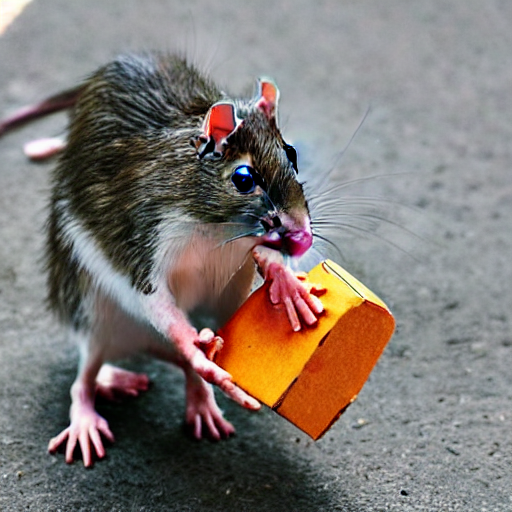


✅ Complete Workflow with Image Generation Finished!
Example workflow with image generation ready!

💡 Quick Tips for M1 MacBook Pro:
1. Start with 'sd15' model (smallest, fastest)
2. Use 512x512 resolution for faster generation
3. Set num_inference_steps=4 for turbo models
4. Monitor memory usage with Activity Monitor
5. Use 'sdxl_turbo' for best balance of speed/quality


In [58]:
# Example: Complete workflow with image generation
# Uncomment and run this example to test the full pipeline


# Set your data paths
POSTS_FILE = "../posts_data.json"
IMAGES_DIR = "/Users/sayems_mac/BrandReview/brandReviewModels/RAG_pipeline/images"

# Example parameters
TEXT_QUERY = "koi delivery chan?"
GENERATE_IMAGE = "../images/2025-09-23.jpg"
GENERATE_CAPTION = "koi delivery chan?"

# Image generation parameters
GENERATE_IMAGES = True  # Set to True to enable image generation
IMAGE_GEN_MODEL = "sd15"  # Options: sdxl_turbo, sd15, sdxl_lightning, flux_dev
NUM_IMAGES = 3  # Number of images to generate

# Get image files
from pathlib import Path
def normalize_image_inputs(images_dir_or_list, recursive=True):
    exts = {".jpg", ".jpeg", ".png", ".webp", ".bmp"}
    def collect_dir(d: Path):
        it = d.rglob("*") if recursive else d.glob("*")
        return [str(fp) for fp in it if fp.is_file() and fp.suffix.lower() in exts]

    if isinstance(images_dir_or_list, (list, tuple)):
        files = []
        for item in images_dir_or_list:
            p = Path(item)
            if p.is_dir():
                files.extend(collect_dir(p))
            elif p.is_file() and p.suffix.lower() in exts:
                files.append(str(p))
        return files

    p = Path(images_dir_or_list)
    if p.is_dir():
        return collect_dir(p)
    if p.is_file():
        return [str(p)]
    raise FileNotFoundError(f"Path not found: {p}")

image_files = normalize_image_inputs(IMAGES_DIR)

# Run the complete workflow with image generation
run_complete_workflow_with_image_generation(
    posts_json=POSTS_FILE,
    images_dir=image_files,
    query_text=TEXT_QUERY,
    generate_image=GENERATE_IMAGE,
    generate_caption=GENERATE_CAPTION,
    generate_images_from_caption=GENERATE_IMAGES,
    image_gen_model=IMAGE_GEN_MODEL,
    num_generated_images=NUM_IMAGES
)

print("Example workflow with image generation ready!")
print("\n💡 Quick Tips for M1 MacBook Pro:")
print("1. Start with 'sd15' model (smallest, fastest)")
print("2. Use 512x512 resolution for faster generation")
print("3. Set num_inference_steps=4 for turbo models")
print("4. Monitor memory usage with Activity Monitor")
print("5. Use 'sdxl_turbo' for best balance of speed/quality")


## 9. Complete Workflow Example {#workflow}

This section demonstrates the complete multimodal RAG workflow from data ingestion to content generation.

**Workflow Steps:**
1. **Data Ingestion**: Load and embed posts data
2. **Text Search**: Find similar content using text query
3. **Content Generation**: Generate new content using retrieved examples
4. **Image Search**: Find similar images using image query
5. **Results Display**: Show search results and generated content


In [59]:


# def run_complete_workflow(posts_json: str, images_dir: str, 
#                          query_text: str = None, query_image: str = None,
#                          generate_image: str = None, generate_caption: str = ""):
#     """
#     Run the complete multimodal RAG workflow.
    
#     Args:
#         posts_json: Path to posts data file
#         images_dir: Directory containing images
#         query_text: Text query for search (optional)
#         query_image: Image path for search (optional)
#         generate_image: Image path for content generation (optional)
#         generate_caption: Caption for content generation (optional)
#     """
#     print("🚀 Starting Complete Multimodal RAG Workflow")
#     print("=" * 60)
    
#     # Step 1: Data Ingestion
#     print("\n📥 Step 1: Data Ingestion")
#     ingest(posts_json, images_dir)
    
#     hits = []
    
#     # Step 2: Search (Text or Image)
#     if query_text:
#         print(f"\n🔍 Step 2: Text Search for '{query_text}'")
#         # Initial text search
#         hits = search_by_text(query_text, TOPK_INIT)
#         print(f"Found {len(hits)} initial results")
        
#         # Advanced post-processing
#         hits = post_process_for_text_query(query_text, hits, images_dir)
#         print(f"After reranking and diversification: {len(hits)} results")
        
#     elif query_image:
#         print(f"\n🔍 Step 2: Image Search for '{query_image}'")
#         hits = search_by_image(query_image, TOPK_INIT)
#         print(f"Found {len(hits)} similar images")
    
#     # Step 3: Display Results
#     if hits:
#         print(f"\n📋 Step 3: Search Results")
#         print("-" * 40)
#         for i, h in enumerate(hits, 1):
#             payload = h['payload']
#             print(f"[{i}] Score: {h['score']:.3f}")
#             print(f"    Image: {payload.get('image', 'N/A')}")
#             print(f"    Caption: {payload.get('caption', 'N/A')[:80]}...")
#             print(f"    Description: {payload.get('description', 'N/A')[:80]}...")
#             print()
    
#     # Step 4: Content Generation
#     if generate_image and hits:
#         print(f"\n✨ Step 4: Content Generation")
#         print(f"Generating content for image: {generate_image}")
#         print(f"Caption: {generate_caption}")
#         print(f"Using {len(hits[:3])} examples as style reference...")
        
#         try:
#             generated_desc = gen_with_qwen_vl(generate_image, generate_caption, hits[:3])
#             print(f"\n🎯 Generated Description:")
#             print(f"'{generated_desc}'")
#         except Exception as e:
#             print(f"❌ Generation failed: {e}")
    
#     print("\n✅ Workflow Complete!")
#     print("=" * 60)

# print("Complete workflow function defined successfully!")


## 10. Example Usage {#examples}

Now let's run some examples to demonstrate the multimodal RAG system in action.

**Note**: Make sure you have the data files (`posts_data.json` and images directory) in the correct location before running these examples.


In [60]:
# # Example 1: Complete workflow with text search and content generation
# # Uncomment and modify the paths below to run this example


# # Set your data paths
# POSTS_FILE = "../posts_data.json"  # Path to your posts data
# IMAGES_DIR = "/Users/sayems_mac/BrandReview/brandReviewModels/RAG_pipeline/images"           # Path to your images directory

# # Example text query
# TEXT_QUERY = "rainy day scene"

# # Example content generation
# GENERATE_IMAGE = "../images/2025-09-23.jpg"  # Path to image for generation
# GENERATE_CAPTION = "oi mama !"


# from pathlib import Path

# def normalize_image_inputs(images_dir_or_list, recursive=True):
#     exts = {".jpg", ".jpeg", ".png", ".webp", ".bmp"}
#     def collect_dir(d: Path):
#         it = d.rglob("*") if recursive else d.glob("*")
#         return [str(fp) for fp in it if fp.is_file() and fp.suffix.lower() in exts]

#     if isinstance(images_dir_or_list, (list, tuple)):
#         files = []
#         for item in images_dir_or_list:
#             p = Path(item)
#             if p.is_dir():
#                 files.extend(collect_dir(p))
#             elif p.is_file() and p.suffix.lower() in exts:
#                 files.append(str(p))
#         return files

#     p = Path(images_dir_or_list)
#     if p.is_dir():
#         return collect_dir(p)
#     if p.is_file():
#         return [str(p)]
#     raise FileNotFoundError(f"Path not found: {p}")

# # Update your call:
# image_files = normalize_image_inputs(IMAGES_DIR) 

# # Run the complete workflow

# run_complete_workflow(
#     posts_json=POSTS_FILE,
#     images_dir=image_files,
#     query_text=TEXT_QUERY,
#     generate_image=GENERATE_IMAGE,
#     generate_caption=GENERATE_CAPTION
# )


In [61]:
# Example 2: Individual function usage
# Uncomment sections below to test individual components

"""
# Test data loading
print("=== Testing Data Loading ===")
posts = load_json_any("../posts_data.json")
print(f"Loaded {len(posts)} posts")
if posts:
    print(f"Sample post keys: {list(posts[0].keys())}")
    print(f"Sample post: {posts[0]}")

# Test embedding functions
print("\n=== Testing Embeddings ===")
if posts:
    # Test text embedding
    sample_text = posts[0].get('caption', '') + ' ' + posts[0].get('description', '')
    text_emb = emb_text([sample_text], mode="passage")
    print(f"Text embedding shape: {text_emb.shape}")
    
    # Test image embedding (if image exists)
    sample_image = f"../images/{posts[0]['image']}"
    if os.path.exists(sample_image):
        img_emb = emb_image([sample_image])
        print(f"Image embedding shape: {img_emb.shape}")

# Test search functions (after ingestion)
print("\n=== Testing Search ===")
# First run ingestion
ingest("../posts_data.json", "../images")

# Test text search
results = search_by_text("rainy day", 5)
print(f"Text search returned {len(results)} results")

# Test image search (if image exists)
if posts and os.path.exists(f"../images/{posts[0]['image']}"):
    img_results = search_by_image(f"../images/{posts[0]['image']}", 5)
    print(f"Image search returned {len(img_results)} results")
"""

print("Individual function test code ready!")


Individual function test code ready!


## 11. Advanced Features {#advanced}

This section covers advanced features and customization options.

### 11.1 Configuration Tuning

**Retrieval Parameters:**
- `TOPK_INIT`: Number of initial candidates (higher = more recall, slower)
- `TOPK_FINAL`: Final number of results (lower = more focused)
- `MMR_LAMBDA`: Diversification vs relevance balance (0.7 = good default)
- `DEDUP_THR`: Deduplication threshold (0.96 = strict, 0.9 = lenient)

**Model Selection:**
- Image embeddings: CLIP variants (ViT-B/32, ViT-L/14, ViT-H/14)
- Text embeddings: E5 variants (small, base, large) or other multilingual models
- Generation: Qwen2.5-VL variants (3B, 7B, 14B, 72B)

### 11.2 Performance Optimization

**For Large Datasets:**
- Use Qdrant server mode for persistence
- Batch embedding generation
- Implement embedding caching
- Use GPU acceleration for models

**For Production:**
- Implement async processing
- Add error handling and retries
- Monitor embedding quality
- Cache generated content


In [62]:
# Advanced configuration examples
# Uncomment and modify as needed

"""
# Performance tuning examples
PERFORMANCE_CONFIG = {
    # For faster processing (lower quality)
    "fast": {
        "TOPK_INIT": 12,
        "TOPK_FINAL": 3,
        "MMR_LAMBDA": 0.5,
        "DEDUP_THR": 0.9,
        "IMG_EMB": "sentence-transformers/clip-ViT-B-32",
        "GEN_MODEL_ID": "Qwen/Qwen2.5-VL-3B-Instruct"
    },
    
    # For high quality (slower processing)
    "quality": {
        "TOPK_INIT": 50,
        "TOPK_FINAL": 10,
        "MMR_LAMBDA": 0.8,
        "DEDUP_THR": 0.98,
        "IMG_EMB": "sentence-transformers/clip-ViT-H-14",
        "GEN_MODEL_ID": "Qwen/Qwen2.5-VL-72B-Instruct"
    }
}

# Apply configuration
def apply_config(config_name):
    config = PERFORMANCE_CONFIG[config_name]
    globals().update(config)
    print(f"Applied {config_name} configuration")

# Example usage:
# apply_config("fast")  # For quick testing
# apply_config("quality")  # For production quality
"""

print("Advanced configuration examples ready!")


Advanced configuration examples ready!


## 12. Troubleshooting and Tips {#troubleshooting}

### Common Issues and Solutions

**Memory Issues:**
- Use smaller models for development (CLIP ViT-B/32, Qwen2.5-VL-3B)
- Process data in batches
- Use `torch.no_grad()` for inference

**Slow Performance:**
- Enable GPU acceleration
- Use in-memory Qdrant for small datasets
- Cache embeddings to avoid recomputation
- Reduce `TOPK_INIT` and `TOPK_FINAL`

**Poor Search Results:**
- Check embedding quality with sample queries
- Adjust MMR_LAMBDA for better diversity/relevance balance
- Verify text preprocessing (E5 prefixing)
- Ensure image paths are correct

**Generation Issues:**
- Verify model compatibility with your hardware
- Check image format (should be RGB)
- Ensure sufficient GPU memory for generation model
- Try different temperature and top_p values

### Data Format Requirements

**Posts JSON Format:**
```json
[
  {
    "image": "filename.jpg",
    "caption": "Image caption",
    "description": "Detailed description",
    "date": "2025-01-01",
    "engagement": {"likes": 100, "comments": 5}
  }
]
```

**Image Requirements:**
- Supported formats: JPG, PNG, WEBP
- Automatic RGB conversion
- Reasonable file sizes (< 10MB recommended)


## 13. Conclusion {#conclusion}

This notebook demonstrates a complete multimodal RAG system that combines:

### Key Features Implemented:
- ✅ **Multimodal Embeddings**: CLIP for images, E5 for text
- ✅ **Vector Database**: Qdrant with multi-vector support
- ✅ **Advanced Retrieval**: MMR diversification and deduplication
- ✅ **Cross-modal Reranking**: CLIP text-image similarity
- ✅ **Content Generation**: Qwen2.5-VL for style-consistent output
- ✅ **Multilingual Support**: E5 model supports multiple languages

### System Architecture:
```
Data → Embeddings → Vector DB → Search → Rerank → Generate
```

### Use Cases:
- **Content Creation**: Generate social media descriptions
- **Image Search**: Find similar images by text or image
- **Style Transfer**: Adapt content to match existing examples
- **Multilingual RAG**: Support for non-English queries

### Next Steps:
1. **Scale Up**: Use server-mode Qdrant for production
2. **Fine-tune**: Adapt models to your specific domain
3. **Monitor**: Add logging and performance metrics
4. **Deploy**: Create API endpoints for production use

### Resources:
- [Qdrant Documentation](https://qdrant.tech/documentation/)
- [Sentence Transformers](https://www.sbert.net/)
- [Qwen2.5-VL Model](https://huggingface.co/Qwen/Qwen2.5-VL-7B-Instruct)
- [CLIP Model](https://huggingface.co/sentence-transformers/clip-ViT-L-14)

---

**Happy Building! 🚀**

*This notebook provides a solid foundation for building sophisticated multimodal RAG applications. Feel free to modify and extend it for your specific needs.*
